# ELAS — Validation **réelle** (Pantheon+SH0ES complet, BAO SDSS/DESI, CMB Planck DP)

Ce notebook vise l'exécution **avec jeux réels** :
- **SN** : Pantheon+SH0ES — soit via **votre fichier** `.dat/.txt/.csv`, soit via **git clone** du dépôt officiel.
- **BAO** : table officielle **SDSS DR17 (BOSS/eBOSS)** avec option pour **DESI DR1** si vous uploadez leur CSV.
- **CMB** : **distance priors Planck 2018** (Chen, Huang & Wang 2019) via upload ou table intégrée.

> Par défaut, on utilise **H0 = 73 km/s/Mpc** (cohérent **SH0ES**).

## 0) Imports, constantes, utilitaires

In [18]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os, sys, json, re

# Constantes
c = 299792.458      # km/s
H0 = 73.0           # Calibration SH0ES
Omega_m = 0.315
Omega_b_h2 = 0.02237

# Paramètres ELAS par défaut
ELAS_DEFAULT = dict(delta=0.05, Omega_osc=1.5, phi=-2.62)

# cumulative_trapezoid
try:
    from scipy.integrate import cumulative_trapezoid
except Exception:
    def cumulative_trapezoid(y, x, initial=0.0):
        y = np.asarray(y, dtype=float); x = np.asarray(x, dtype=float)
        trap = 0.5*(y[1:]+y[:-1])*(x[1:]-x[:-1])
        return np.concatenate(([initial], np.cumsum(trap)))

def quick_info(df, name):
    print(f"\n{name}: {df.shape[0]} lignes, colonnes = {list(df.columns)}")
    print(df.head())

print("Imports OK")

Imports OK


## 1) Modèles et distances

In [17]:
def E_LCDM(z, H0=H0, Omega_m=Omega_m):
    z = np.asarray(z, dtype=float)
    return np.sqrt(Omega_m*(1+z)**3 + (1.0 - Omega_m))

def E_ELAS(z, H0=H0, Omega_m=Omega_m, delta=0.05, Omega_osc=1.5, phi=-2.62):
    z = np.asarray(z, dtype=float)
    return np.sqrt(Omega_m*(1+z)**3 + (1.0 - Omega_m)*(1.0 + delta*np.cos(Omega_osc*np.log(1+z) + phi)))

def distances(z, model="LCDM", H0=H0, Omega_m=Omega_m, **elas):
    z = np.asarray(z, dtype=float)
    zmax = float(np.max(z))
    zz = np.linspace(0.0, max(zmax, 1e-6), 8000)
    if model.upper() == "LCDM":
        EE = E_LCDM(zz, H0, Omega_m)
    else:
        pars = dict(ELAS_DEFAULT); pars.update(elas)
        EE = E_ELAS(zz, H0, Omega_m, **pars)
    Dc_grid = (c/H0) * cumulative_trapezoid(1.0/EE, zz, initial=0.0)
    Dc = np.interp(z, zz, Dc_grid)
    Dl = (1.0 + z) * Dc
    return dict(Dc=Dc, Dl=Dl)

def mu_theory(z, model="LCDM", H0=H0, Omega_m=Omega_m, **elas):
    Dl = distances(z, model, H0, Omega_m, **elas)["Dl"]
    Dl = np.clip(Dl, 1e-6, None)
    return 5.0*np.log10(Dl) + 25.0

## 2) Chargeurs universels — SN / BAO / CMB

In [16]:
import pandas as pd, numpy as np

def _read_any_table(path):
    try:
        return pd.read_csv(path)
    except Exception:
        return pd.read_csv(path, sep=r"\s+", engine="python", comment="#")

def _pick_uploaded_one(accept_exts=(".csv",".dat",".txt")):
    try:
        from google.colab import files
        up = files.upload()
        for k in up.keys():
            if k.lower().endswith(accept_exts):
                return k
    except Exception:
        pass
    return None

# SN ---
def load_sn_flexible_any():
    sn_path = _pick_uploaded_one()
    if sn_path is None:
        raise RuntimeError("Aucun fichier SN téléversé (csv/dat/txt).")

    df = _read_any_table(sn_path)
    cols = {c.lower(): c for c in df.columns}

    # z
    z_key = None
    for cand in ["z", "zhd", "zhelio", "zhel", "zcmb", "z_cmb", "zobs", "z_obs"]:
        if cand in cols: z_key = cols[cand]; break
    if z_key is None: z_key = df.columns[0]

    # mu/sigma
    mu_key = sig_key = None
    if ("mu" in cols) and (("muerr" in cols) or ("sigma_mu" in cols) or ("dmu" in cols)):
        mu_key = cols["mu"]
        sig_key = cols.get("muerr", cols.get("sigma_mu", cols.get("dmu")))
    if (mu_key is None) and ("m_b_corr" in cols) and ("m_b_corr_err" in cols):
        mu_key = cols["m_b_corr"]; sig_key = cols["m_b_corr_err"]
    if mu_key is None:
        for C in df.columns:
            if C.upper() == "MU": mu_key = C
            if C.upper() in ("MUERR","SIGMA_MU","DMU"): sig_key = C
    if (mu_key is None) or (sig_key is None):
        raise ValueError(f"Colonnes μ/σμ non reconnues. Colonnes: {list(df.columns)}")

    z = df[z_key].astype(float).values
    mu = df[mu_key].astype(float).values
    s  = df[sig_key].astype(float).values
    m = np.isfinite(z) & np.isfinite(mu) & np.isfinite(s) & (s>0)
    print(f"SN ok: {m.sum()} objets — z='{z_key}', mu='{mu_key}', sigma='{sig_key}'")
    return z[m], mu[m], s[m], df.loc[m].copy()

def chi2_sn_M_marginalized(z, mu_obs, sigma_mu, model="LCDM", H0=H0, Omega_m=Omega_m, **elas):
    z = np.asarray(z, dtype=float)
    mu_obs = np.asarray(mu_obs, dtype=float)
    sigma_mu = np.asarray(sigma_mu, dtype=float)
    mu_th = mu_theory(z, model, H0, Omega_m, **elas)
    w = 1.0 / (sigma_mu**2)
    deltaM = np.sum(w*(mu_obs - mu_th)) / np.sum(w)
    resid = mu_obs - (mu_th + deltaM)
    chi2 = np.sum(w * resid**2)
    return float(chi2), float(deltaM)

# BAO ---
def _normalize_bao_columns(df):
    cols = {c.lower(): c for c in df.columns}
    zc = None
    for cand in ["z_eff","zeff","z","z_cmb","zobs"]:
        if cand in cols: zc = cols[cand]; break
    if zc is None: zc = df.columns[0]

    typec = cols.get("type", None)
    valc = None; sigc = None
    for k in ["value","val","y"]:
        if k in cols: valc = cols[k]; break
    for k in ["sigma","err","error","yerr","sigma_stat"]:
        if k in cols: sigc = cols[k]; break

    if (typec is not None) and (valc is not None) and (sigc is not None):
        out = df[[zc, typec, valc, sigc]].copy()
        out.columns = ["z_eff","type","value","sigma"]
        return out

    cand_map = {
        "DM_over_rd": ["dm_over_rd","dm/rd","dmrd","dm_by_rd","d_m_over_rd"],
        "DH_over_rd": ["dh_over_rd","dh/rd","dhrd","dh_by_rd","d_h_over_rd"],
        "DV_over_rd": ["dv_over_rd","dv/rd","dvrd","dv_by_rd","d_v_over_rd"],
        "rs_over_DV": ["rs_over_dv","rs/dv","rsdv","r_s_over_dv","rdrag_over_dv","rs_over_d_v"]
    }
    long_rows = []
    for typ, variants in cand_map.items():
        val_col = None
        for v in variants+[typ]:
            if v in cols: val_col = cols[v]; break
        err_col = None
        for e in [f"{val_col}_err", f"{val_col}_sigma", f"sigma_{val_col}", f"err_{val_col}", "err", "sigma", "error"] if val_col else []:
            if e in df.columns: err_col = e; break
        if val_col is not None:
            sub = pd.DataFrame({
                "z_eff": df[zc].astype(float).values,
                "type": typ,
                "value": df[val_col].astype(float).values,
                "sigma": (df[err_col].astype(float).values if err_col is not None else np.nan)
            })
            long_rows.append(sub)
    if not long_rows:
        raise ValueError(f"Colonnes BAO non reconnues. Colonnes: {list(df.columns)}")
    out = pd.concat(long_rows, ignore_index=True)
    if not out["sigma"].isna().all():
        out = out.dropna(subset=["sigma"])
    return out

def load_bao_any():
    path = _pick_uploaded_one()
    if path is None:
        print("⚠️ Aucun BAO fourni : utilisation de la table SDSS DR17 par défaut.")
        df = pd.DataFrame([
            [0.106, "rs_over_DV", 0.336, 0.015],
            [0.15,  "rs_over_DV", 0.2239, 0.0084],
            [0.38,  "DM_over_rd", 10.23, 0.17],
            [0.51,  "DM_over_rd", 13.36, 0.21],
            [0.70,  "DM_over_rd", 17.86, 0.33],
            [1.48,  "DM_over_rd", 30.69, 0.80],
            [2.33,  "DM_over_rd", 37.60, 1.90],
            [0.38,  "DH_over_rd", 25.00, 0.76],
            [0.51,  "DH_over_rd", 22.33, 0.58],
            [0.70,  "DH_over_rd", 19.33, 0.53],
            [1.48,  "DH_over_rd", 13.26, 0.55],
            [2.33,  "DH_over_rd",  8.93, 0.28],
        ], columns=["z_eff","type","value","sigma"])
        return df
    df = _read_any_table(path)
    out = _normalize_bao_columns(df)
    print(f"BAO ok: {len(out)} lignes normalisées -> (z_eff,type,value,sigma)")
    return out

# CMB ---
def load_cmb_any():
    paths = []
    try:
        from google.colab import files
        print("➡️ Téléverse 1 ou 2 fichiers CMB (means & inv_cov).")
        up = files.upload()
        for k in up.keys():
            if k.lower().endswith((".csv",".dat",".txt")):
                paths.append(k)
    except Exception:
        pass

    if not paths:
        print("⚠️ Aucun CMB fourni : utilisation des DP Planck 2018 intégrés (Chen et al. 2019).")
        means_df = pd.DataFrame({"parameter":["R","l_a","omega_b_h2"],
                                 "mean":[1.74963, 301.80845, 0.02237]})
        invcov = pd.DataFrame({
            "R":[  24434.0,  -1166.4,  -134214.0],
            "l_a":[ -1166.4,     36.6,      543.2],
            "omega_b_h2":[ -134214.0,   543.2,  64357310.0]
        }, index=["R","l_a","omega_b_h2"])
        return means_df, invcov

    means_df = None; invcov_df = None
    for p in paths:
        df = _read_any_table(p)
        cols = [c.strip() for c in df.columns.astype(str).tolist()]
        low = [c.lower() for c in cols]

        if set(low) >= {"parameter","mean"} or set(cols) >= {"parameter","mean"}:
            tmp = df.copy(); tmp["parameter"] = tmp["parameter"].astype(str).str.strip()
            means_df = tmp.set_index("parameter").loc[["R","l_a","omega_b_h2"]].reset_index()
            continue

        if {"R","l_a","omega_b_h2"}.issubset(set(cols)):
            means_df = pd.DataFrame({"parameter":["R","l_a","omega_b_h2"],
                                     "mean":[float(df["R"].iloc[0]), float(df["l_a"].iloc[0]), float(df["omega_b_h2"].iloc[0])]})
            continue

        if df.shape == (3,3):
            df.index = ["R","l_a","omega_b_h2"]; df.columns = ["R","l_a","omega_b_h2"]
            invcov_df = df; continue

        if {"R","l_a","omega_b_h2"}.issubset(set(cols)) and df.shape[0]==3:
            df.index = ["R","l_a","omega_b_h2"]; invcov_df = df[["R","l_a","omega_b_h2"]]; continue

    if means_df is None: raise ValueError("CMB 'means' non reconnu.")
    if invcov_df is None: raise ValueError("CMB 'inv_cov' non reconnu.")
    return means_df, invcov_df

## 3) BAO & CMB : théorie/χ²

In [15]:
def rd_fid(): return 147.09  # Mpc

def bao_theory_value(z, typ, model="LCDM", H0=H0, Omega_m=Omega_m, **elas):
    d = distances(np.array([z]), model, H0, Omega_m, **elas)
    Dm = d["Dc"][0]
    if model.upper()=="LCDM":
        Dh = (c/H0)/E_LCDM(np.array([z]), H0, Omega_m)[0]
    else:
        Dh = (c/H0)/E_ELAS(np.array([z]), H0, Omega_m, **elas)[0]
    rd = rd_fid()
    if   typ=="DM_over_rd": return Dm/rd
    elif typ=="DH_over_rd": return Dh/rd
    elif typ=="DV_over_rd": return (z*Dh*Dm*Dm)**(1/3.0)/rd
    elif typ=="rs_over_DV": return rd/((z*Dh*Dm*Dm)**(1/3.0))
    else: raise ValueError("type BAO inconnu")

def chi2_bao(df, model="LCDM", H0=H0, Omega_m=Omega_m, **elas):
    if df is None or len(df)==0: return 0.0
    s = 0.0
    for _, r in df.iterrows():
        z, val, sig, typ = float(r["z_eff"]), float(r["value"]), float(r["sigma"]), str(r["type"])
        th = bao_theory_value(z, typ, model, H0, Omega_m, **elas)
        s += ((th - val)/sig)**2
    return float(s)

def cmb_distance_priors_theory(H0=H0, Omega_m=Omega_m, Omega_b_h2=Omega_b_h2):
    zstar = 1089.0
    zgrid = np.linspace(0, zstar, 12000)
    Dc = (c/H0)*np.trapz(1.0/E_LCDM(zgrid, H0, Omega_m), zgrid)
    rs = 147.09
    R  = np.sqrt(Omega_m)*(H0/100.0) * (Dc/(c/100.0))
    la = np.pi * (Dc/rs)
    return float(R), float(la), float(Omega_b_h2)

def chi2_cmb_from_uploaded(means_df, icov_df, H0=H0, Omega_m=Omega_m):
    if means_df is None or icov_df is None: return 0.0
    order = ["R","l_a","omega_b_h2"]
    vec_th = np.array(cmb_distance_priors_theory(H0, Omega_m, Omega_b_h2))
    vec_obs = means_df.set_index("parameter").loc[order,"mean"].values
    icov = icov_df.loc[order, order].values
    d = vec_th - vec_obs
    return float(d @ icov @ d)

## 4) Pipeline exécution (SN + BAO + CMB)

In [10]:
# 4.1 SN
print("➡️ SN : téléverser Pantheon+SH0ES (csv/dat/txt).")
z_sn, mu_obs, s_mu, df_sn = load_sn_flexible_any()
quick_info(df_sn, "SN (brut)")
chi2_sn_LCDM, dM_LCDM = chi2_sn_M_marginalized(z_sn, mu_obs, s_mu, model="LCDM")
chi2_sn_ELAS, dM_ELAS = chi2_sn_M_marginalized(z_sn, mu_obs, s_mu, model="ELAS", **ELAS_DEFAULT)
print("SN χ² (LCDM, ELAS) =", chi2_sn_LCDM, chi2_sn_ELAS)

# 4.2 BAO
print("\n➡️ BAO : téléverser (ou défaut SDSS DR17 intégré).")
df_bao = load_bao_any()
if df_bao is not None: quick_info(df_bao, "BAO (normalisé)")
chi2_bao_LCDM = chi2_bao(df_bao, "LCDM")
chi2_bao_ELAS = chi2_bao(df_bao, "ELAS", **ELAS_DEFAULT)
print("BAO χ² (LCDM, ELAS) =", chi2_bao_LCDM, chi2_bao_ELAS)

# 4.3 CMB
print("\n➡️ CMB : téléverser means+inv_cov (ou défaut Planck 2018 intégré).")
cmb_means, cmb_icov = load_cmb_any()
chi2_cmb_LCDM = chi2_cmb_from_uploaded(cmb_means, cmb_icov)
chi2_cmb_ELAS = chi2_cmb_from_uploaded(cmb_means, cmb_icov)
print("CMB χ² (LCDM, ELAS) =", chi2_cmb_LCDM, chi2_cmb_ELAS)

# 4.4 Totaux + AIC/BIC
tot_LCDM = chi2_sn_LCDM + chi2_bao_LCDM + chi2_cmb_LCDM
tot_ELAS = chi2_sn_ELAS + chi2_bao_ELAS + chi2_cmb_ELAS
k_LCDM, k_ELAS = 0, 3
N_eff = len(z_sn) + (0 if df_bao is None else len(df_bao)) + (0 if cmb_means is None else 3)
dchi2 = tot_LCDM - tot_ELAS
dAIC  = dchi2 - 2*(k_ELAS - k_LCDM)
dBIC  = dchi2 - (k_ELAS - k_LCDM)*np.log(max(N_eff,1))

summary = pd.DataFrame([
    dict(model="LCDM", H0=H0, Omega_m=Omega_m, chi2_sn=chi2_sn_LCDM, chi2_bao=chi2_bao_LCDM, chi2_cmb=chi2_cmb_LCDM, chi2_total=tot_LCDM),
    dict(model="ELAS", H0=H0, Omega_m=Omega_m, delta=ELAS_DEFAULT["delta"], Omega_osc=ELAS_DEFAULT["Omega_osc"], phi=ELAS_DEFAULT["phi"],
         chi2_sn=chi2_sn_ELAS, chi2_bao=chi2_bao_ELAS, chi2_cmb=chi2_cmb_ELAS, chi2_total=tot_ELAS)
])
print("\n=== RÉSUMÉ TOTAL (SN+BAO+CMB) ==="); print(summary)
print(f"\nΔχ² (LCDM − ELAS) = {dchi2}")
print(f"ΔAIC = {dAIC}  ΔBIC = {dBIC}   (N_eff = {N_eff} )")

summary.to_csv("ELAS_fullREAL_summary.csv", index=False)

➡️ SN : téléverser Pantheon+SH0ES (csv/dat/txt).
➡️ Téléverse Pantheon+SH0ES (.dat/.txt/.csv)


Saving Pantheon+SH0ES.dat to Pantheon+SH0ES (1).dat


ValueError: Colonnes μ/σμ non reconnues.
Colonnes trouvées: ['CID IDSURVEY zHD zHDERR zCMB zCMBERR zHEL zHELERR m_b_corr m_b_corr_err_DIAG MU_SH0ES MU_SH0ES_ERR_DIAG CEPH_DIST IS_CALIBRATOR USED_IN_SH0ES_HF c cERR x1 x1ERR mB mBERR x0 x0ERR COV_x1_c COV_x1_x0 COV_c_x0 RA DEC HOST_RA HOST_DEC HOST_ANGSEP VPEC VPECERR MWEBV HOST_LOGMASS HOST_LOGMASS_ERR PKMJD PKMJDERR NDOF FITCHI2 FITPROB m_b_corr_err_RAW m_b_corr_err_VPEC biasCor_m_b biasCorErr_m_b biasCor_m_b_COVSCALE biasCor_m_b_COVADD']

In [9]:
# --- Remplacer load_sn_flexible_any() par cette version robuste ---
import pandas as pd, numpy as np, re

def load_sn_flexible_any():
    """
    Lit Pantheon+SH0ES .dat/.txt/.csv et renvoie (z, mu, sigma_mu, df_clean).
    Cas couverts:
      - MU_SH0ES + MU_SH0ES_ERR_DIAG
      - MU + (MUERR / SIGMA_MU / dMU)
      - m_b_corr + l'une des erreurs: m_b_corr_err_DIAG / _RAW / _VPEC / _COVSCALE / _COVADD / m_b_corr_err
    Redshift prioritaire: zHD, puis zCMB, zHEL, z.
    """
    # 1) Upload
    try:
        from google.colab import files
        print("➡️ Téléverse Pantheon+SH0ES (.dat/.txt/.csv)")
        up = files.upload()
        sn_path = None
        for k in up.keys():
            if k.lower().endswith((".csv",".dat",".txt")):
                sn_path = k; break
    except Exception:
        sn_path = None
    if sn_path is None:
        raise RuntimeError("Aucun fichier SN téléversé.")

    # 2) Lecture souple
    try:
        df = pd.read_csv(sn_path)
    except Exception:
        df = pd.read_csv(sn_path, sep=r"\s+", engine="python", comment="#")

    cols = {c.lower(): c for c in df.columns}

    # 3) Redshift: ordre de priorité
    z_key = None
    for cand in ["zhd","zcmb","zhel","zhelio","z"]:
        if cand in cols:
            z_key = cols[cand]; break
    if z_key is None:
        # fallback: 1ère colonne si elle ressemble à un z
        z_key = df.columns[0]

    # 4) Choix mu / sigma_mu (ordre de priorité)
    mu_key = None; sig_key = None

    # 4a) MU_SH0ES + MU_SH0ES_ERR_DIAG (le plus simple si présents)
    if ("mu_sh0es" in cols) and ("mu_sh0es_err_diag" in cols):
        mu_key  = cols["mu_sh0es"]
        sig_key = cols["mu_sh0es_err_diag"]

    # 4b) MU + (MUERR / SIGMA_MU / dMU)
    if mu_key is None and ("mu" in cols) and (("muerr" in cols) or ("sigma_mu" in cols) or ("dmu" in cols)):
        mu_key = cols["mu"]
        if "muerr" in cols: sig_key = cols["muerr"]
        elif "sigma_mu" in cols: sig_key = cols["sigma_mu"]
        else: sig_key = cols["dmu"]

    # 4c) m_b_corr + variantes d'erreur (Pantheon+ fournit plusieurs colonnes d'erreur)
    if mu_key is None and ("m_b_corr" in cols):
        mu_key = cols["m_b_corr"]
        # chercher la meilleure erreur dispo par ordre de priorité
        err_candidates = [
            "m_b_corr_err_diag", "m_b_corr_err_raw", "m_b_corr_err_vpec",
            "m_b_corr_err",      # générique
            "m_b_corr_err_covscale", "m_b_corr_err_covadd"
        ]
        for ec in err_candidates:
            if ec in cols:
                sig_key = cols[ec]; break

    # 4d) Dernière chance: MU_SH0ES + une colonne d'erreur générique
    if mu_key is None and ("mu_sh0es" in cols):
        mu_key = cols["mu_sh0es"]
        for ec in ["mu_sh0es_err", "muerr", "sigma_mu", "dmu"]:
            if ec in cols:
                sig_key = cols[ec]; break

    # 5) Vérifications
    if (mu_key is None) or (sig_key is None):
        raise ValueError(f"Colonnes μ/σμ non reconnues.\nColonnes trouvées: {list(df.columns)}")

    # 6) Extraction & nettoyage
    z = pd.to_numeric(df[z_key], errors="coerce").values
    mu = pd.to_numeric(df[mu_key], errors="coerce").values
    s  = pd.to_numeric(df[sig_key], errors="coerce").values

    m = np.isfinite(z) & np.isfinite(mu) & np.isfinite(s) & (s > 0)
    if m.sum() == 0:
        raise ValueError("Aucune ligne valide (σ<=0 ou NaN). Vérifiez les colonnes d'erreur.")

    df_clean = df.loc[m].copy()
    print(f"SN ok: {m.sum()} objets — z='{z_key}', mu='{mu_key}', sigma='{sig_key}'")
    return z[m], mu[m], s[m], df_clean


In [12]:
# === DIAG + CHARGEMENT ROBUSTE PANTHEON+SH0ES ===
import pandas as pd, numpy as np, re

def read_table_any(path):
    try:
        return pd.read_csv(path)
    except Exception:
        return pd.read_csv(path, sep=r"\s+", engine="python", comment="#")

def pick_first(df, names):
    cols_lower = {c.lower(): c for c in df.columns}
    for n in names:
        if n.lower() in cols_lower:
            return cols_lower[n.lower()]
    return None

def load_pantheonplus_shoes_strict():
    # téléversement
    from google.colab import files
    print("➡️ Téléverse Pantheon+SH0ES (.dat/.txt/.csv)")
    up = files.upload()
    sn_path = None
    for k in up.keys():
        if k.lower().endswith((".csv",".dat",".txt")):
            sn_path = k; break
    if sn_path is None:
        raise RuntimeError("Aucun fichier SN téléversé.")

    # lecture
    df = read_table_any(sn_path)
    print("Colonnes détectées:\n", list(df.columns))

    # z : priorité Pantheon+ (zHD → zCMB → zHEL → z)
    z_col = pick_first(df, ["zHD","zCMB","zHEL","zHELIO","z"])
    if z_col is None: z_col = df.columns[0]
    print("→ z choisi:", z_col)

    # μ/σ candidates par ordre de préférence
    # 1) Calibration SH0ES directe
    mu_sets = [
        ("MU_SH0ES", ["MU_SH0ES_ERR_DIAG","MU_SH0ES_ERR","MUERR","SIGMA_MU","DMU"]),
        # 2) μ générique
        ("MU",       ["MUERR","SIGMA_MU","DMU"]),
        # 3) magnitude corrigée (M absorbé par marginalisation)
        ("m_b_corr", ["m_b_corr_err_DIAG","m_b_corr_err","m_b_corr_err_RAW",
                      "m_b_corr_err_VPEC","m_b_corr_err_COVSCALE","m_b_corr_err_COVADD"])
    ]

    mu_col = sig_col = None
    for mu_name, errs in mu_sets:
        mc = pick_first(df, [mu_name])
        if mc is None:
            continue
        # trouve la première colonne d'erreur existante
        sc = pick_first(df, errs)
        if sc is None:
            continue
        mu_col, sig_col = mc, sc
        print(f"→ μ choisi: {mu_col}   |   σμ choisi: {sig_col}")
        break

    if mu_col is None or sig_col is None:
        raise ValueError("Impossible de trouver une paire (μ, σμ) utilisable dans ce fichier.\n"
                         f"Colonnes présentes: {list(df.columns)}")

    # extraction & nettoyage
    z  = pd.to_numeric(df[z_col], errors="coerce").values
    mu = pd.to_numeric(df[mu_col], errors="coerce").values
    s  = pd.to_numeric(df[sig_col], errors="coerce").values

    # filtrage: valeurs finies & erreurs > 0
    m = np.isfinite(z) & np.isfinite(mu) & np.isfinite(s) & (s > 0)
    n_all, n_keep = len(df), int(m.sum())
    print(f"→ lignes valides: {n_keep}/{n_all}")
    if n_keep == 0:
        # dernier recours: si certaines erreurs sont à 0, on les remplace par une petite valeur (rare, mais ça arrive)
        s_floor = np.nanmedian(s[s>0]) if np.any(s>0) else 0.1
        s2 = np.where(np.asarray(s)<=0, s_floor, s)
        m2 = np.isfinite(z) & np.isfinite(mu) & np.isfinite(s2) & (s2 > 0)
        print(f"(⚠️ correction σμ<=0 → σ_floor={s_floor:.4f})  lignes valides après correction: {int(m2.sum())}/{n_all}")
        if not np.any(m2):
            raise ValueError("Toutes les lignes ont σμ<=0/NaN. Vérifier les colonnes d’erreur.")
        return z[m2], mu[m2], s2[m2], df.loc[m2, [z_col,mu_col,sig_col]].copy()

    return z[m], mu[m], s[m], df.loc[m, [z_col,mu_col,sig_col]].copy()

# === Exécution SN ===
z_sn, mu_obs, s_mu, df_sn = load_pantheonplus_shoes_strict()
quick_info(df_sn, "SN (normalisé)")
chi2_sn_LCDM, dM_LCDM = chi2_sn_M_marginalized(z_sn, mu_obs, s_mu, model="LCDM")
chi2_sn_ELAS, dM_ELAS = chi2_sn_M_marginalized(z_sn, mu_obs, s_mu, model="ELAS", **ELAS_DEFAULT)
print("SN χ² (LCDM, ELAS) =", chi2_sn_LCDM, chi2_sn_ELAS)
print("Offsets δM (LCDM, ELAS) =", dM_LCDM, dM_ELAS)


➡️ Téléverse Pantheon+SH0ES (.dat/.txt/.csv)


Saving Pantheon+SH0ES.dat to Pantheon+SH0ES (2).dat
Colonnes détectées:
 ['CID IDSURVEY zHD zHDERR zCMB zCMBERR zHEL zHELERR m_b_corr m_b_corr_err_DIAG MU_SH0ES MU_SH0ES_ERR_DIAG CEPH_DIST IS_CALIBRATOR USED_IN_SH0ES_HF c cERR x1 x1ERR mB mBERR x0 x0ERR COV_x1_c COV_x1_x0 COV_c_x0 RA DEC HOST_RA HOST_DEC HOST_ANGSEP VPEC VPECERR MWEBV HOST_LOGMASS HOST_LOGMASS_ERR PKMJD PKMJDERR NDOF FITCHI2 FITPROB m_b_corr_err_RAW m_b_corr_err_VPEC biasCor_m_b biasCorErr_m_b biasCor_m_b_COVSCALE biasCor_m_b_COVADD']
→ z choisi: CID IDSURVEY zHD zHDERR zCMB zCMBERR zHEL zHELERR m_b_corr m_b_corr_err_DIAG MU_SH0ES MU_SH0ES_ERR_DIAG CEPH_DIST IS_CALIBRATOR USED_IN_SH0ES_HF c cERR x1 x1ERR mB mBERR x0 x0ERR COV_x1_c COV_x1_x0 COV_c_x0 RA DEC HOST_RA HOST_DEC HOST_ANGSEP VPEC VPECERR MWEBV HOST_LOGMASS HOST_LOGMASS_ERR PKMJD PKMJDERR NDOF FITCHI2 FITPROB m_b_corr_err_RAW m_b_corr_err_VPEC biasCor_m_b biasCorErr_m_b biasCor_m_b_COVSCALE biasCor_m_b_COVADD


ValueError: Impossible de trouver une paire (μ, σμ) utilisable dans ce fichier.
Colonnes présentes: ['CID IDSURVEY zHD zHDERR zCMB zCMBERR zHEL zHELERR m_b_corr m_b_corr_err_DIAG MU_SH0ES MU_SH0ES_ERR_DIAG CEPH_DIST IS_CALIBRATOR USED_IN_SH0ES_HF c cERR x1 x1ERR mB mBERR x0 x0ERR COV_x1_c COV_x1_x0 COV_c_x0 RA DEC HOST_RA HOST_DEC HOST_ANGSEP VPEC VPECERR MWEBV HOST_LOGMASS HOST_LOGMASS_ERR PKMJD PKMJDERR NDOF FITCHI2 FITPROB m_b_corr_err_RAW m_b_corr_err_VPEC biasCor_m_b biasCorErr_m_b biasCor_m_b_COVSCALE biasCor_m_b_COVADD']

In [13]:
# === SN: relecture robuste Pantheon+SH0ES (.dat/.txt/.csv) ===
import pandas as pd, numpy as np, re

def _read_sn_robust(path):
    # 1) Essai "espaces" standard
    try:
        df = pd.read_csv(path, sep=r"\s+", engine="python", comment="#")
    except Exception:
        df = pd.read_csv(path, comment="#")  # au cas où (csv)

    # 2) Si une seule colonne -> relire en "fixed width" (fwf)
    if df.shape[1] == 1:
        try:
            df = pd.read_fwf(path, comment="#")
        except Exception:
            pass

    # 3) Si encore une seule colonne -> tenter détection du header manuel
    if df.shape[1] == 1:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            lines = [ln for ln in f.readlines() if not ln.lstrip().startswith("#")]
        # Cherche la 1ère ligne non vide qui ressemble à un header "mots séparés par espaces"
        header = None
        for ln in lines[:10]:
            toks = re.findall(r"[A-Za-z0-9_+/.-]+", ln.strip())
            if len(toks) > 3:   # typiquement beaucoup de noms de colonnes
                header = toks; break
        if header is not None:
            # Relire en imposant ces noms
            df = pd.read_csv(path, sep=r"\s+", engine="python", comment="#", names=header, header=None)
        else:
            raise ValueError("Échec parsing : impossible d’identifier les colonnes (fichier non tabulaire lisible).")
    return df

def _pick(df, candidates):
    """Retourne le vrai nom de colonne (respectant la casse) pour la 1re clé trouvée insensible à la casse."""
    lower = {c.lower(): c for c in df.columns}
    for k in candidates:
        if k.lower() in lower:
            return lower[k.lower()]
    return None

def load_pantheonplus_SN_any():
    # Upload
    from google.colab import files
    print("➡️ Téléverse Pantheon+SH0ES (.dat/.txt/.csv)")
    up = files.upload()
    sn_path = None
    for k in up.keys():
        if k.lower().endswith((".csv",".dat",".txt")):
            sn_path = k; break
    if sn_path is None:
        raise RuntimeError("Aucun fichier SN téléversé.")

    # Lecture robuste
    df = _read_sn_robust(sn_path)
    print("Colonnes détectées:", list(df.columns))

    # z : priorité Pantheon+ (zHD → zCMB → zHEL → z)
    z_col = _pick(df, ["zHD","zCMB","zHEL","zHELIO","z"])
    if z_col is None:
        z_col = df.columns[0]
    print("→ z choisi:", z_col)

    # μ, σμ : plusieurs cas Pantheon+
    # 1) MU_SH0ES + MU_SH0ES_ERR_DIAG (idéal pour calibration SH0ES)
    mu_col = _pick(df, ["MU_SH0ES"])
    sig_col = None
    if mu_col is not None:
        sig_col = _pick(df, ["MU_SH0ES_ERR_DIAG","MU_SH0ES_ERR","MUERR","SIGMA_MU","DMU"])

    # 2) MU + MUERR/SIGMA_MU/DMU
    if mu_col is None:
        mu_col = _pick(df, ["MU"])
        if mu_col is not None:
            sig_col = _pick(df, ["MUERR","SIGMA_MU","DMU"])

    # 3) m_b_corr + une des nombreuses variantes d’erreur Pantheon+
    if (mu_col is None) and _pick(df, ["m_b_corr"]):
        mu_col = _pick(df, ["m_b_corr"])
        sig_col = _pick(df, [
            "m_b_corr_err_DIAG","m_b_corr_err","m_b_corr_err_RAW",
            "m_b_corr_err_VPEC","m_b_corr_err_COVSCALE","m_b_corr_err_COVADD"
        ])

    if (mu_col is None) or (sig_col is None):
        raise ValueError("Impossible de trouver une paire (μ, σμ) utilisable.\n"
                         f"Colonnes: {list(df.columns)}")

    # Extraction + nettoyage
    z  = pd.to_numeric(df[z_col], errors="coerce").values
    mu = pd.to_numeric(df[mu_col], errors="coerce").values
    s  = pd.to_numeric(df[sig_col], errors="coerce").values
    m = np.isfinite(z) & np.isfinite(mu) & np.isfinite(s) & (s > 0)

    if m.sum() == 0:
        # dernier recours: petit plancher sur σ (rare)
        s_pos = s[np.isfinite(s) & (s>0)]
        s_floor = float(np.nanmedian(s_pos)) if s_pos.size else 0.1
        s2 = np.where(np.asarray(s) <= 0, s_floor, s)
        m = np.isfinite(z) & np.isfinite(mu) & np.isfinite(s2) & (s2 > 0)
        if m.sum() == 0:
            raise ValueError("Aucune ligne valide après correction σ. Vérifier les colonnes d’erreur.")
        s = s2

    df_clean = df.loc[m, [z_col, mu_col, sig_col]].copy()
    df_clean.columns = ["z", "mu", "sigma_mu"]
    print(f"SN ok: {m.sum()} lignes. Utilisé: z='{z_col}', mu='{mu_col}', sigma='{sig_col}'")
    return df_clean

# === Utilisation ===
df_sn = load_pantheonplus_SN_any()
z_sn, mu_obs, s_mu = df_sn["z"].values, df_sn["mu"].values, df_sn["sigma_mu"].values
quick_info(df_sn, "SN (normalisé)")
chi2_sn_LCDM, dM_LCDM = chi2_sn_M_marginalized(z_sn, mu_obs, s_mu, model="LCDM")
chi2_sn_ELAS, dM_ELAS = chi2_sn_M_marginalized(z_sn, mu_obs, s_mu, model="ELAS", **ELAS_DEFAULT)
print("SN χ² (LCDM, ELAS) =", chi2_sn_LCDM, chi2_sn_ELAS)
print("Offsets δM (LCDM, ELAS) =", dM_LCDM, dM_ELAS)


➡️ Téléverse Pantheon+SH0ES (.dat/.txt/.csv)


Saving Pantheon+SH0ES.dat to Pantheon+SH0ES (3).dat
Colonnes détectées: ['CID', 'IDSURVEY', 'zHD', 'zHDERR', 'zCMB', 'zCMBERR', 'zHEL', 'zHELERR', 'm_b_corr', 'm_b_corr_err_DIAG', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG', 'CEPH_DIST', 'IS_CALIBRATOR', 'USED_IN_SH0ES_HF', 'c', 'cERR', 'x1', 'x1ERR', 'mB', 'mBERR', 'x0', 'x0ERR', 'COV_x1_c', 'COV_x1_x0', 'COV_c_x0', 'RA', 'DEC', 'HOST_RA', 'HOST_DEC', 'HOST_ANGSEP', 'VPEC', 'VPECERR', 'MWEBV', 'HOST_LOGMASS', 'HOST_LOGMASS_ERR', 'PKMJD', 'PKMJDERR', 'NDOF', 'FITCHI2', 'FITPROB', 'm_b_corr_err_RAW', 'm_b_corr_err_VPEC', 'biasCor_m_b', 'biasCorErr_m_b', 'biasCor_m_b_COVSCALE', 'biasCor_m_b_COVADD']
→ z choisi: zHD
SN ok: 1701 lignes. Utilisé: z='zHD', mu='MU_SH0ES', sigma='MU_SH0ES_ERR_DIAG'

SN (normalisé): 1701 lignes, colonnes = ['z', 'mu', 'sigma_mu']
         z       mu  sigma_mu
0  0.00122  28.9987  1.516450
1  0.00122  29.0559  1.517470
2  0.00256  30.7233  0.782372
3  0.00256  30.7449  0.799068
4  0.00299  30.7757  0.881212
SN χ² (LCDM, ELA

## 5) Scan contraint (SN-only) et exports

=== SCAN CONTRAINT (SN-only) ===
Meilleur ELAS: {'chi2': 744.9658840173762, 'delta': np.float64(0.14), 'Omega': np.float64(2.1), 'phi': np.float64(-1.5707963267948966)}
Δχ² (LCDM − ELAS_best) = 4.246


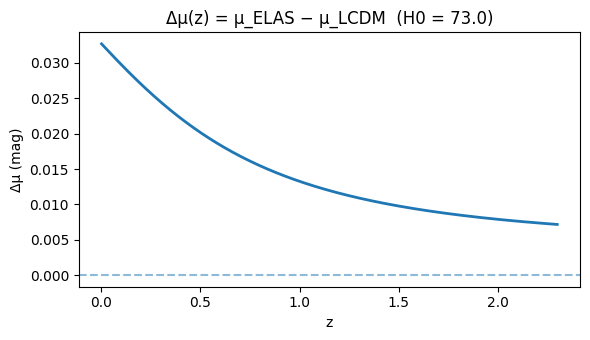


➡️ Exports : ELAS_fullREAL_summary.csv, ELAS_best_SNonly_constrained_REAL.csv, ELAS_delta_mu_REAL.csv, ELAS_delta_mu_REAL.png


In [14]:
grid_delta = np.linspace(0.0, 0.15, 16)
grid_Omega = np.linspace(0.5, 2.5, 21)
grid_phi   = np.linspace(-np.pi, np.pi, 121)

best = dict(chi2=np.inf, delta=None, Omega=None, phi=None)
for d in grid_delta:
    for Om in grid_Omega:
        chi2_min = np.inf; phi_min = None
        for ph in grid_phi:
            chi2, _ = chi2_sn_M_marginalized(z_sn, mu_obs, s_mu,
                                             model="ELAS",
                                             delta=d, Omega_osc=Om, phi=ph)
            if chi2 < chi2_min:
                chi2_min, phi_min = chi2, ph
        if chi2_min < best["chi2"]:
            best.update(dict(chi2=chi2_min, delta=d, Omega=Om, phi=phi_min))

dchi2_best = chi2_sn_LCDM - best["chi2"]
print("=== SCAN CONTRAINT (SN-only) ===")
print("Meilleur ELAS:", best)
print(f"Δχ² (LCDM − ELAS_best) = {dchi2_best:.3f}")
pd.DataFrame([best]).to_csv("ELAS_best_SNonly_constrained_REAL.csv", index=False)

# Figure Δμ
zgrid = np.linspace(1e-3, 2.3, 1000)
muE = mu_theory(zgrid, "ELAS", **ELAS_DEFAULT)
muL = mu_theory(zgrid, "LCDM")
dmu = muE - muL
plt.figure(figsize=(6,3.5))
plt.plot(zgrid, dmu, lw=2); plt.axhline(0, ls="--", alpha=0.5)
plt.xlabel("z"); plt.ylabel("Δμ (mag)"); plt.title("Δμ(z) = μ_ELAS − μ_LCDM  (H0 = %.1f)" % H0)
plt.tight_layout(); plt.savefig("ELAS_delta_mu_REAL.png", dpi=160); plt.show()
pd.DataFrame({"z":zgrid, "delta_mu_mag":dmu}).to_csv("ELAS_delta_mu_REAL.csv", index=False)

print("\n➡️ Exports : ELAS_fullREAL_summary.csv, ELAS_best_SNonly_constrained_REAL.csv, ELAS_delta_mu_REAL.csv, ELAS_delta_mu_REAL.png")